In [136]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
stopwords = nltk.corpus.stopwords.words('english')
import string
import re
from collections import Counter

### Load Dataset and drop unnecessary columns

In [137]:
df = pd.read_csv("labeled_data.csv")
df=df.drop(df.index[3000:])
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Visualization of dataset for output(Imbalanced Dataset)

Dataset size: (3000, 7)


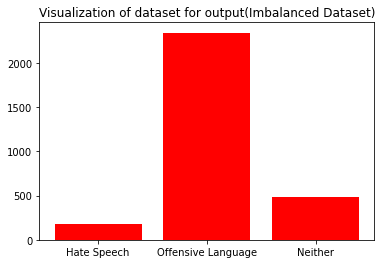

In [138]:
flags = ["Hate Speech", "Offensive Language", "Neither"]
values = [df[df["class"] == i].shape[0] for i in range(3)]
plt.bar(flags, values, color="red")
plt.title("Visualization of dataset for output(Imbalanced Dataset)")
print(f"Dataset size: {df.shape}")
plt.show()

### Over sampling for this imbalanced dataset

In [139]:
ros = RandomOverSampler(random_state=0)
tweet_resampled, class_resampled = ros.fit_resample(np.array(list(df["tweet"])).reshape(-1, 1), list(df["class"]))
tweet_resampled = np.array([tweet[0] for tweet in tweet_resampled])
print(f"Dataset size after oversampling: {len(tweet_resampled)}")

Dataset size after oversampling: 7020


### Visualization of dataset after applying oversampling

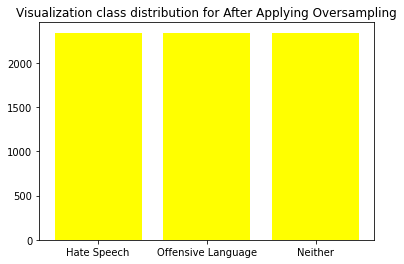

In [140]:
values = [class_resampled.count(i) for i in range(3)]
plt.bar(flags, values, color="yellow")
plt.title("Visualization class distribution for After Applying Oversampling")
plt.show()

### Preprocessing
#### Steps
* Removing Punctuations
* Removing URLs
* Removing Stop Words
* Lower Casing
* Tokenization
* Stemming
* Lemmatization

Reference: https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

In [141]:
# Punctuation Removal

def remove_punctuation(text):
    punctuation_free = "".join([i for i in text if i not in string.punctuation]).strip()
    return punctuation_free 

In [142]:
# Tokenization

def tokenize(text): # Reference: https://pynative.com/python-regex-split/
    tokens = re.split(r"\s+", text)
    return tokens

In [143]:
# Remove Stopwords

def remove_stopwords(text):
    removed_stopwords = [i for i in text if i not in stopwords]
    return removed_stopwords

In [144]:
# Lemmatization

wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    lemmatized_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemmatized_text

In [145]:
# # Preprocess the resampled text data

tweets_punctuation_free = np.array([remove_punctuation(tweet) for tweet in tweet_resampled])
tweets_lowercase = np.array([tweet.lower() for tweet in tweets_punctuation_free])
tweets_tokenized = np.array([tokenize(tweet) for tweet in tweets_lowercase], dtype=object)
tweets_no_stop_words = np.array([remove_stopwords(tweet) for tweet in tweets_tokenized], dtype=object)
tweets_no_stop_words = np.array([remove_stopwords(tweet) for tweet in tweets_tokenized], dtype=object)
tweets_lemmatized = np.array([lemmatize(tweet) for tweet in tweets_no_stop_words], dtype=object)

### Additional Preprocessing Steps..
Some additional preprocessing steps for better result such as 'URL removal' and 'Spell Correction' will be implemented later if time permits <br>
Reference URL Removal: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python

### Feature Extraction - Bag of Word using Monograms

In [146]:
# Feature Extraction using Count Vectorization

from itertools import count

vectorizer = CountVectorizer()
tweets_lemmatized_str = [" ".join(tweet) for tweet in tweets_lemmatized]
count_vectorized_tweets = vectorizer.fit_transform(tweets_lemmatized_str).toarray()

In [147]:
# Split the dataset between Train and Test Set

X_train, X_test, y_train, y_test = train_test_split(count_vectorized_tweets, class_resampled, test_size=0.2, random_state=42, shuffle=True)

### Fit the models
Algorithms
* Logistic Regression
* Naive Bayes Classifier
* Kth Nearest Neighbor

### Logistic Regression

In [148]:
reg = LogisticRegression()
reg.fit(X_train, y_train)
reg_y_predict = reg.predict(X_test)
reg_cf_matrix = confusion_matrix(y_test, reg_y_predict)
reg_score = reg.score(X_test, y_test)
print(reg_score)

0.9686609686609686


### Naive Bayes Classifier

In [149]:
nvc = GaussianNB()
nvc.fit(X_train, y_train)
nvc_y_predict = nvc.predict(X_test)
nvc_cf_matrix = confusion_matrix(y_test, nvc_y_predict)
nvc_score = nvc.score(X_test, y_test)
print(nvc_score)

0.9166666666666666


## Kth Nearest Neighbor

In [150]:
knn = KNN(n_neighbors = 3)
knn.fit(X_train, y_train)
knn_y_predict = knn.predict(X_test)
knn_cf_matrix = confusion_matrix(y_test, knn_y_predict)
knn_score = knn.score(X_test, y_test)
print(knn_score)

0.9316239316239316


### Confusion Matrix, Precision, Recall and F1 Score for Each Model

In [151]:
# Reference: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=Plot%20Confusion%20Matrix%20for%20Binary%20Classes%20With%20Labels&text=You%20need%20to%20create%20a,matrix%20with%20the%20labels%20annotation.

def display_confusion_matrix(cf_matrix, model_name, color_map): 
    dataframe_cfm = pd.DataFrame(cf_matrix, range(3), range(3))
    plt.figure(figsize = (7,5))
    ax = sns.heatmap(dataframe_cfm, annot=True, fmt='', cmap=color_map)
    ax.set_title(f'Confusion Matrix for {model_name} \n\n');
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('Actual Label');
    ax.xaxis.set_ticklabels(['0','1', "2"])
    ax.yaxis.set_ticklabels(['hate_speech','offensive_language', "neither"])
    plt.show()

In [152]:
# Calculate Precision, Recall and F1 Scores

precision_scores = [precision_score(y_test, reg.predict(X_test), average=None), precision_score(y_test, nvc.predict(X_test), average=None), precision_score(y_test, knn.predict(X_test), average=None)]
recall_scores = [recall_score(y_test, reg.predict(X_test), average=None), recall_score(y_test, nvc.predict(X_test), average=None), recall_score(y_test, knn.predict(X_test), average=None)]
f1_scores = [f1_score(y_test, reg.predict(X_test), average=None), f1_score(y_test, nvc.predict(X_test), average=None), f1_score(y_test, knn.predict(X_test), average=None)]

     precision     recall     f1_score
0    0.96           1.0       0.98
1    1.0           0.91       0.95
2    0.95           1.0       0.97


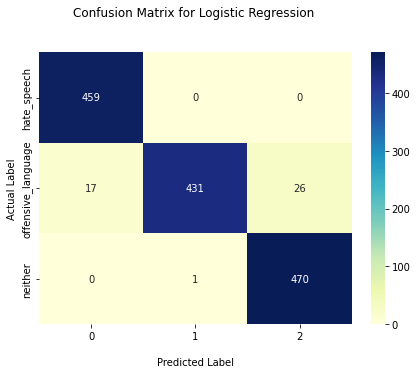

In [153]:
# Confusion Matrix for Logistic Regression Model
print("     precision     recall     f1_score")
for i in range(3):
    print(f"{i}    {round(precision_scores[0][i], 2)}           {round(recall_scores[0][i], 2)}       {round(f1_scores[0][i], 2)}")

display_confusion_matrix(reg_cf_matrix, "Logistic Regression", "YlGnBu")

     precision     recall     f1_score
0    0.89           1.0        0.94
1    0.98           0.77        0.86
2    0.89           0.99        0.94


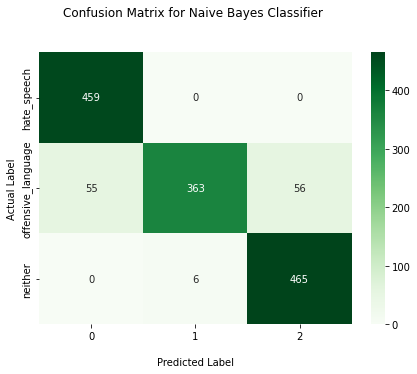

In [154]:
# Confusion Matrix for Naive Bayes Classifier Model

print("     precision     recall     f1_score")
for i in range(3):
    print(f"{i}    {round(precision_scores[1][i], 2)}           {round(recall_scores[1][i], 2)}        {round(f1_scores[1][i], 2)}")

display_confusion_matrix(nvc_cf_matrix, "Naive Bayes Classifier", "Greens")

     precision     recall     f1_score
0    0.93          1.0        0.97
1    0.99          0.81        0.89
2    0.88          0.99        0.93


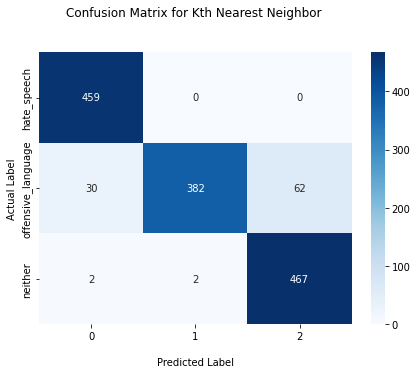

In [155]:
# Confusion Matrix for Kth Nearest Neighbor Model

print("     precision     recall     f1_score")
for i in range(3): 
    print(f"{i}    {round(precision_scores[2][i], 2)}          {round(recall_scores[2][i], 2)}        {round(f1_scores[2][i], 2)}")


display_confusion_matrix(knn_cf_matrix, "Kth Nearest Neighbor", "Blues")